## Chemprop model evaluation

To further evaluate the model's performance, over 10k melting points were retrieved from pubchem(more in the "pubchem_scraping" folder). The recovered data are in "PubChem_mpC.csv" file. We can see whether model performance correlates with molecule complexity.

In [1]:
import pandas as pd
import chemprop
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

In order to compare predicted vs. actual, we need to predict the melting point for all scraped smiles from pubchem. The following cell use chemprop to do this and create a csv with a new column "mpC" wich is the predicted melting point in celsius. The cells has already been run, the data can simply be loaded.

In [2]:
"""
# Make predictions using the trained model
arguments = [
    '--test_path', '../Data/scrapping/pubchem_scraped_mpC.csv',
    '--preds_path', '../Data/scrapping/pubchem_preds.csv',
    '--checkpoint_dir', '../scripts',
    '--features_generator', 'rdkit_2d_normalized',  
    '--no_features_scaling',
    '--smiles_columns', 'canonicalsmiles'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)
"""
# Load the results data
df = pd.read_csv('../Data/scrapping/pubchem_preds.csv')

In [3]:
# Rename mpC in preds
df.rename(columns={'mpC': 'mpC_preds'}, inplace=True)
# Select only the columns we need
df = df[['cid', 'mpC_preds', 'pubchem_mpC', 'canonicalsmiles', 'complexity']]
df.head()

,cid,mpC_preds,pubchem_mpC,canonicalsmiles,complexity
0,118856773,167.21085969454992,65°C,CCC(C)C1C(=O)NC(C(=O)NCC(=O)NC(C(=O)NC(C(=O)NC...,18600
1,139600825,167.21085969454992,65°C,CCC(C)C1C(=O)NC(C(=O)NCC(=O)NC(C(=O)NC(C(=O)NC...,18600
2,16130295,147.96367848110611,>100 °C,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N...,16700
3,22833874,147.96367848110611,>100 °C,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N...,16700
4,129627711,147.96367848110611,>100 °C,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N...,16700


We need to clean the pubchem mpC column and exctract float from it. The following function extracts a float melting point from recurring formats in scraped data. If no format matches, we'll simply drop this data

In [4]:
import re

def extract_melting_point(melting_point):
    # Convert to lowercase and check for the presence of "decompose", "decomposes", "<", or ">"
    if any(keyword in melting_point.lower() for keyword in ["decompose", "<", ">"]):
        return None

    # Check for a range of temperatures, including possible negative values
    range_match = re.search(r"(-?\d+)\s*-\s*(-?\d+)\s*°C", melting_point)
    if range_match:
        # Calculate the mean of the range
        low_temp = float(range_match.group(1))
        high_temp = float(range_match.group(2))
        return (low_temp + high_temp) / 2
    else:
        # Check for a single temperature, including possible negative values
        single_match = re.search(r"(-?\d+)\s*°C", melting_point)
        if single_match:
            return float(single_match.group(1))
        else:
            return None  # Return None if no pattern matches

In [5]:
# Apply the function to the 'pubchem_mpC' column
df['pubchem_mpC'] = df['pubchem_mpC'].apply(extract_melting_point)
df = df.dropna(subset=['pubchem_mpC'])

In [6]:
# insure that 'pubchem_mpC' and complexity columns are float
df['mpC_preds'] = df['mpC_preds'].astype(float)
df['complexity'] = df['complexity'].astype(float)

In order to analyze rigourously the model, we have to removed all compounds that were in the training set

In [7]:
# Load the training set
train_df = pd.read_csv("../Data/splitting_for_training/train.csv")
train_df.head(5)

,smiles,mpC
0,CC(=O)c1ccc2c(c1)NC(=O)CO2,196.0
1,C1CCC2=NCCCN2CC1,-70.0
2,CC(=O)NC12CC3CC(CC(C3)C1)C2,148.0
3,NC(=O)c1ccc(F)cc1,156.0
4,Cc1ccc2c(c1)C(c1ccccc1)C(c1ccccc1)N2,155.0


In [8]:
# Ensure that all smiles are canonical smiles with molfromsmiles and smilesfrommol
def canonical_smiles(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
train_df['canonical_smiles'] = train_df['smiles'].apply(canonical_smiles)
df['canonical_smiles'] = df['canonicalsmiles'].apply(canonical_smiles)

[16:13:35] WARNING: not removing hydrogen atom without neighbors
[16:13:35] WARNING: not removing hydrogen atom without neighbors
[16:13:35] WARNING: not removing hydrogen atom without neighbors
[16:13:35] WARNING: not removing hydrogen atom without neighbors
[16:13:35] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not removing hydrogen atom without neighbors
[16:13:37] WARNING: not r

In [30]:
# Remove all canonical_smiles in df that are in train_df
df_filtered = df[~df['canonical_smiles'].isin(train_df['canonical_smiles'])]
df_filtered.head()

,cid,mpC_preds,pubchem_mpC,canonicalsmiles,complexity,canonical_smiles
0,118856773,167.210860,65.0,CCC(C)C1C(=O)NC(C(=O)NCC(=O)NC(C(=O)NC(C(=O)NC...,18600.0,CCC(C)C1NC(=O)C2CSSCC(NC(=O)C(CC(C)C)NC(=O)C3C...
1,139600825,167.210860,65.0,CCC(C)C1C(=O)NC(C(=O)NCC(=O)NC(C(=O)NC(C(=O)NC...,18600.0,CCC(C)C1NC(=O)C2CSSCC(NC(=O)C(CC(C)C)NC(=O)C3C...
10,18772499,171.027431,178.0,C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)COC3(C(C(C(...,12900.0,OCC1OC(OC2(COC3(COC4(COC5(COC6(COC7(COC8(COC9(...
13,16143525,275.567652,220.5,CC=C1C2=NC(CS2)C(=O)NC(C3=NC(=CS3)C(=S)NC4C(OC...,3850.0,C=C(NC(=O)C(=C)NC(=O)c1csc(C2CCC34NC(=O)C(C)NC...
14,45267103,185.133035,229.0,CC(C)CC(C(=O)NC(C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)...,3790.0,CC(C)CC(NC(=O)CNC(=O)C(NC=O)C(C)C)C(=O)NC(C)C(...


## Analysis

Firstly, let's see how the model perform with an actual vs predicted plot :

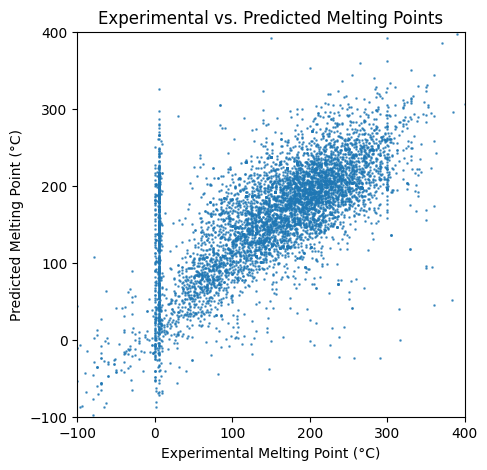

mean absolute error: 50.508592203285836


In [32]:
# Plot the predicted vs. experimental melting points
plt.figure(figsize=(5, 5))
plt.scatter(df_filtered['pubchem_mpC'], df_filtered['mpC_preds'], s = 0.75, alpha=0.7)
plt.xlabel('Experimental Melting Point (°C)')
plt.ylabel('Predicted Melting Point (°C)')
plt.xlim(-100, 400)
plt.ylim(-100, 400)
plt.title('Experimental vs. Predicted Melting Points')
plt.show()

# Calculate the mean absolute error
mae = (df_filtered['mpC_preds'] - df_filtered['pubchem_mpC']).abs().mean()
print(f"mean absolute error: {mae}")

We observe a bias in the data, this line around 5 and 300 aren't normal. On pubchem, some compounds with a melting point above 300°C are simply annouce at 300°C. For values close to 5°C (0 - 10°C), the source of the bias is not known, but a histogram shows that it is indeed an error in the data:

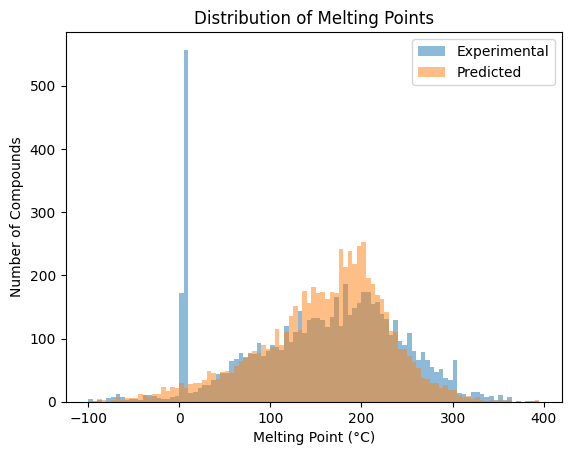

In [33]:
# Histogram of pubchem_mpC with 5 degree bins
plt.hist(df_filtered['pubchem_mpC'], bins=range(-100, 400, 5), alpha=0.5, label='Experimental')
plt.hist(df_filtered['mpC_preds'], bins=range(-100, 400, 5), alpha=0.5, label='Predicted')
plt.xlabel('Melting Point (°C)')
plt.ylabel('Number of Compounds')
plt.title('Distribution of Melting Points')
plt.legend()
plt.show()


Other way to clean the data can be used. But to simplify, these values will be filtered out :

In [34]:
# Create a new df with pubchem_mpC between 0 and 10, and 299-300 removed
df_filtered = df_filtered[(df_filtered['pubchem_mpC'] < 0) | (df_filtered['pubchem_mpC'] > 10) & (df_filtered['pubchem_mpC'] < 299) | (df_filtered['pubchem_mpC'] > 301)]


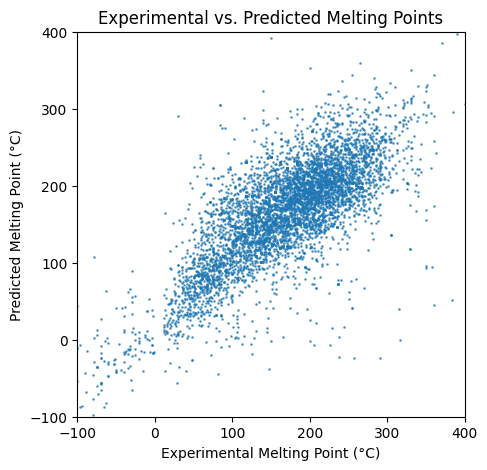

mean absolute error: 42.199522056547735


In [35]:
# Plot the predicted vs. experimental melting points
plt.figure(figsize=(5, 5))
plt.scatter(df_filtered['pubchem_mpC'], df_filtered['mpC_preds'], s = 0.75, alpha=0.7)
plt.xlabel('Experimental Melting Point (°C)')
plt.ylabel('Predicted Melting Point (°C)')
plt.xlim(-100, 400)
plt.ylim(-100, 400)
plt.title('Experimental vs. Predicted Melting Points')
plt.show()
# Print the mean absolute error
mae_filtered = (df_filtered['mpC_preds'] - df_filtered['pubchem_mpC']).abs().mean()
print(f"mean absolute error: {mae_filtered}")

## Factor that can be correlated to the error 

A good thing to do to improve a model is to identify when and why it performs poorly. We will now try to identify a factor that has an impact on the model error. 

### Complexity

Let's see if the molecules complexity is correlated with the mae :

In [36]:
# Add an error column to the df_filtered DataFrame
df_filtered.loc[:, 'error'] = (df_filtered['mpC_preds'] - df_filtered['pubchem_mpC']).abs()
# See the correlation between the error and complexity
correlation = df_filtered['error'].corr(df_filtered['complexity'])
print('Correlation between error and complexity:', correlation)

Correlation between error and complexity: -0.03631350760633894


We see that there is no correlation between the complexity of the molecule and the model prediction error. 

Now, another thing that we can look at is to see if there is a link between the model error and the similarity of a molecule with the training set.

### Similarity with the training set

In order to explore the correlation between error and similarity with the training set, we need a way to estimate the similarity between molecules. Here, we will use the Tanimoto similarity with Morganfingerprint. Let's first compute the similarity matrix of train_df and df_filtered.

In [37]:
# Function to convert SMILES to Morga fingerprints
def smiles_to_fp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:  # Check if molecule conversion is successful
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        return fp
    else:
        return None

# Apply function to convert SMILES to fgp in both DataFrames
train_df['fingerprint'] = train_df['canonical_smiles'].apply(smiles_to_fp)
df_filtered['fingerprint'] = df_filtered['canonical_smiles'].apply(smiles_to_fp)

# Get the similarity matrix between the 2 dataframes
similarity_matrix = []
for test_fp in df_filtered['fingerprint']:
    similarities = [DataStructs.FingerprintSimilarity(test_fp, train_fp) for train_fp in train_df["fingerprint"] if train_fp is not None]
    similarity_matrix.append(similarities)


[16:42:43] WARNING: not removing hydrogen atom without neighbors
[16:42:43] WARNING: not removing hydrogen atom without neighbors
[16:42:43] WARNING: not removing hydrogen atom without neighbors
[16:42:43] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not removing hydrogen atom without neighbors
[16:42:44] WARNING: not r

We can now compute the mean similarity of each molecules in df_filtered with the training molecules :

In [39]:
# Add a mean similarity column to the df_filtered DataFrame
df_filtered["mean_similarity"] = [np.mean(similarities) for similarities in similarity_matrix]
df_filtered.head()

,cid,mpC_preds,pubchem_mpC,canonicalsmiles,complexity,canonical_smiles,error,fingerprint,mean_similarity
0,118856773,167.210860,65.0,CCC(C)C1C(=O)NC(C(=O)NCC(=O)NC(C(=O)NC(C(=O)NC...,18600.0,CCC(C)C1NC(=O)C2CSSCC(NC(=O)C(CC(C)C)NC(=O)C3C...,102.210860,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.046183
1,139600825,167.210860,65.0,CCC(C)C1C(=O)NC(C(=O)NCC(=O)NC(C(=O)NC(C(=O)NC...,18600.0,CCC(C)C1NC(=O)C2CSSCC(NC(=O)C(CC(C)C)NC(=O)C3C...,102.210860,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.046183
10,18772499,171.027431,178.0,C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)COC3(C(C(C(...,12900.0,OCC1OC(OC2(COC3(COC4(COC5(COC6(COC7(COC8(COC9(...,6.972569,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.045021
13,16143525,275.567652,220.5,CC=C1C2=NC(CS2)C(=O)NC(C3=NC(=CS3)C(=S)NC4C(OC...,3850.0,C=C(NC(=O)C(=C)NC(=O)c1csc(C2CCC34NC(=O)C(C)NC...,55.067652,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",0.043641
14,45267103,185.133035,229.0,CC(C)CC(C(=O)NC(C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)...,3790.0,CC(C)CC(NC(=O)CNC(=O)C(NC=O)C(C)C)C(=O)NC(C)C(...,43.866965,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.077061


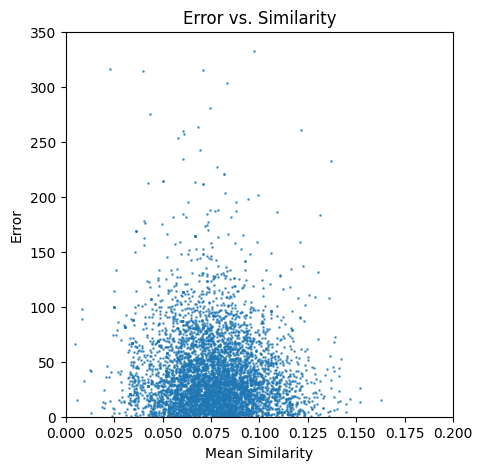

In [40]:
# Plot error vs similarity for the filtered DataFrame 
plt.figure(figsize=(5, 5))
plt.scatter(df_filtered['mean_similarity'], df_filtered['error'], s=0.75, alpha=0.7)
plt.xlabel('Mean Similarity')
plt.ylabel('Error')
plt.xlim(0, 0.2) # (scale adapted to see the main cluster of points)
plt.ylim(0, 350)
plt.title('Error vs. Similarity')
plt.show()

We once again do not observe a signficant trend between similarity and the prediction error, so the model has well generalized from the training data.